The following solution trains a model that determines the sentiment on a given sentence.
The model is trained using the dataset `Sentiment Labelled Sentences` from the _UC Irvine Machine Learning Repository_
available here: https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences.

The dataset is retrieved programatically so we always get an up-to-date version of this dataset.

In [13]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

DATASET_URL = 'https://archive.ics.uci.edu/static/public/331/sentiment+labelled+sentences.zip'

response = urlopen(DATASET_URL)
zip_file = ZipFile(BytesIO(response.read()))

By storing the contents of the Zip file in memory, the archive can be inspected.
We are interested in a `txt` file called `amazon_cells_labelled.txt`

In [14]:
display(zip_file.namelist())

['sentiment labelled sentences/',
 'sentiment labelled sentences/.DS_Store',
 '__MACOSX/',
 '__MACOSX/sentiment labelled sentences/',
 '__MACOSX/sentiment labelled sentences/._.DS_Store',
 'sentiment labelled sentences/amazon_cells_labelled.txt',
 'sentiment labelled sentences/imdb_labelled.txt',
 '__MACOSX/sentiment labelled sentences/._imdb_labelled.txt',
 'sentiment labelled sentences/readme.txt',
 '__MACOSX/sentiment labelled sentences/._readme.txt',
 'sentiment labelled sentences/yelp_labelled.txt',
 '__MACOSX/._sentiment labelled sentences']

The dataset file is fetched from the in-memory opened zip file, contents of the relevant dataset file `amazon_cells_labelled.txt`
are written to disk under `datasets` directory, and finally resources are released.

In [15]:
DATASET_FILE = 'amazon_cells_labelled.txt'
DATASET_PATH = f'sentiment labelled sentences/{DATASET_FILE}'

dataset_zip_file = zip_file.open(DATASET_PATH)
dataset_contents = dataset_zip_file.read()

# Write dataset to disk

dataset_file = open(f'datasets/{DATASET_FILE}', 'wb')
dataset_file.write(dataset_contents)

# Release resources

dataset_file.close()
dataset_zip_file.close()
zip_file.close()


> **Note**
> If you already ran this notebook to this point, you wont need to run the cells above again unless you want to update
> the existing dataset.

In [18]:
import pandas as pd

COL_REVIEW = 'review'
COL_SENTIMENT = 'sentiment'

df = pd.read_csv('datasets/amazon_cells_labelled.txt', names=[COL_REVIEW, COL_SENTIMENT], sep='\t')

display(df)

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


With the dataset in place, we can now split dataset groups for train and testing using _scikit-learn_'s `train_test_split`.
Test group size is made from the 20% of the existing dataset which are 200 samples given that our dataset holds 1000 samples in total.

> Here we aim to the 80/20 pattern also called "Pareto Principle"
> https://en.wikipedia.org/wiki/Pareto_principle

In [20]:
from sklearn.model_selection import train_test_split

reviews = df[COL_REVIEW].values
sentiments = df[COL_SENTIMENT].values

reviews_train, reviews_test, sentiment_train, sentiment_test = train_test_split(reviews, sentiments, test_size=0.2, random_state=500)

Data as available as of this step is presest in its raw state, which means that it still have to be _transformed_ in order to pass it
to a trainning algorithm. For data to be ready for a algorithm to be classified, each sample should be transformed into a _Numerical Feature Vector_, one way to achieve this is using the _Bag of Words_ model.

An example of turning a sentence into a _Numerical Feature Vector_ using _Bag of Words_ model is the following:

```
Text: I love lemonade in a sunny day as I love hot chocolate in a cold day.
BoW: { "I": 2, "love": 2, "lemonade": 1, "in": 2, "a": 2, "sunny": 1, "day": 2, "as": 1, "hot": 1, "chocolate": 1, "cold": 1 }
Vector: [2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1]
```

Scikit-Learn provides the class `CountVectorizer` which can be used to generate the _Bag of Words_ matrix.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# Build the vocabulary of tokens found in the reviews dataset
vectorizer.fit(reviews)

# Creates _Numerical Feature Vectors_ from sets
x_train = vectorizer.transform(reviews_train)
x_test = vectorizer.transform(reviews_test)

With sets turned into Numerical Feature Vectors, we can now train our model.
`LogisticRegression` is used as the classifier algorithm.

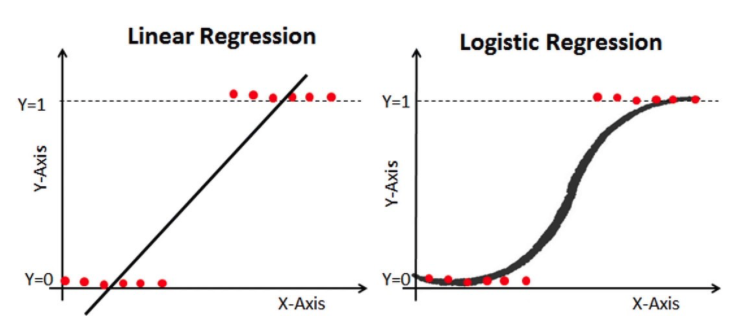

In [26]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

# Trains the model using the `x_train` data fitting it against the `sentiment_train` data
classifier.fit(x_train, sentiment_train)

LogisticRegression()

In [27]:
accurancy = classifier.score(x_test, sentiment_test)
print(f'Accurancy: {accurancy}')

Accurancy: 0.81


With our classifier in place, we can test it against other sentences.

In [34]:
# Create new input sentences
new_reviews = [
    'The new release of Helldivers, "Helldivers II" seems promising',
    'Rust is a blazing fast systems programing language with security and ergonomics in mind',
    'Not good enough if its not cold'
]

# Tokenize sentences
x_new_reviews = vectorizer.transform(new_reviews)

# Print results, 1 for Good Sentiment and 0 for Bad Sentiment
display(classifier.predict(x_new_reviews))

array([1, 1, 0])